<a href="https://colab.research.google.com/github/vasilyryabtsev/futures-price-prediction/blob/dev/ds/twitter/notebooks/ml_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

import warnings

warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
# import torch
import matplotlib.pyplot as plt
import optuna
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.ensemble import StackingClassifier
# from transformers import BertTokenizer, BertForSequenceClassification, pipeline, AutoTokenizer, AutoModelForSequenceClassification
# from gensim.models import Word2Vec
from pipelines.tokenizers import tweet_tokenizer
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from scipy.sparse import hstack, csr_matrix

RANDOM_STATE = 42

# df = pd.read_csv('https://github.com/vasilyryabtsev/futures-price-prediction/blob/dev/ds/twitter/data/processed.csv?raw=true')
df = pd.read_csv('../data/processed.csv')

Xtrain, Xtest, ytrain, ytest = train_test_split(df.drop('1_day_after', axis=1), df['1_day_after'], test_size=0.2, random_state=RANDOM_STATE)

curves = {}

def add_curve(model, name):
    """
    Построение ROC кривой.
    """
    fpr, tpr, thresholds = roc_curve(ytest, model.predict_proba(Xtest)[:, 1])
    roc_auc = auc(fpr, tpr)

    curves[name] = {'fpr': fpr,
                    'tpr': tpr,
                    'thresholds': thresholds,
                    'roc_auc': roc_auc}

def print_metrics(model):
    print(f'ROC-AUC train: {roc_auc_score(ytrain, model.predict_proba(Xtrain)[:, 1])}')
    print(f'ROC-AUC test: {roc_auc_score(ytest, model.predict_proba(Xtest)[:, 1])}')
    print('Classification report for test:')
    print(classification_report(ytest, model.predict(Xtest)))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
Xtrain.shape

(6718, 10)

# Текстовые признаки

## Bag Of Words

### LogisticRegression

In [18]:
ct = ColumnTransformer([
    ("vectorizer", CountVectorizer(tokenizer=tweet_tokenizer), 'text')
], remainder='drop')

pl = Pipeline([
    ("prepocessing",ct),
    ("classifier", LogisticRegression(max_iter=10000, random_state=42))
])

pl.fit(Xtrain, ytrain)

print(f"Number of words in vocabulary: {pl.named_steps['prepocessing']['vectorizer'].get_feature_names_out().shape[0]}")

print_metrics(pl)

Number of words in vocabulary: 8782
ROC-AUC train: 0.9530478632691644
ROC-AUC test: 0.5516647727272728
Classification report for test:
              precision    recall  f1-score   support

           0       0.51      0.49      0.50       800
           1       0.55      0.57      0.56       880

    accuracy                           0.53      1680
   macro avg       0.53      0.53      0.53      1680
weighted avg       0.53      0.53      0.53      1680



In [19]:
add_curve(pl, 'bow-logreg')

with open('../models/bow-logreg.pickle', 'wb') as file:
    pickle.dump(pl, file)

In [22]:
for w in pl.named_steps['prepocessing']['vectorizer'].get_feature_names_out():
    print(w)

#13fpredict
#1776challeng
#3m
#3thingstowatch
#aapl
#aca
#accentur
#ad
#adob
#ai
#allergan
#alphabet
#amazon
#amazonprim
#amazonprimeday
#americassandbox
#amzn
#andtypo
#aol
#appl
#appmesh
#ark
#askforb
#askhowardlindzon
#bank
#bankofamerica
#beat
#beforemanzielgetsdraft
#berkshirehathaway
#bing
#biontech
#biotech
#bitcoin
#blackrock
#boe
#bond
#breakupthebeast
#brexit
#btc
#butposs
#buyout
#buzzwordbingo
#cabl
#cantstopwontstop
#chinesemicrocaporuslargecap
#cisco
#cleanenergi
#clorox
#cloud
#cloudcomput
#cnbccrypto
#cocacola
#coke
#comcast
#confessyourunpopularopinion
#consum
#coronaviru
#corpgov
#corporategovern
#covid19
#crm
#cx
#deliveringalpha
#dinotech
#disappoint
#disney
#dividend
#dividendstock
#dol'
#dominionenergi
#dotcom
#earn
#easycomeeasygo
#easygam
#echo
#economicmoat
#ehhh
#elonmusk
#energi
#equityraisetheroof
#esg
#espn
#etf
#ev
#facebook
#fangtrad
#fcpa
#fedex
#ff
#fia14
#fidel
#firstdayoffal
#firstft
#foia
#forbescio
#gamestop
#generalmil
#gigafactori
#gilead
#googl
#

In [3]:
def objective(trial):
    # CountVectorizer
    max_features = trial.suggest_int("max_features", 100, 6700, step=500)
    ngram_range = trial.suggest_categorical("ngram_range", [(1,1), (1,2), (1,3)])
    min_df = trial.suggest_float("min_df", 1e-5, 0.05, log=True)
    max_df = trial.suggest_float("max_df", 0.5, 1.0)
    
    ct = ColumnTransformer([
        ("vectorizer", CountVectorizer(
            tokenizer=tweet_tokenizer,
            max_features=max_features,
            ngram_range=ngram_range,
            min_df=min_df,
            max_df=max_df
        ), 'text')
    ], remainder='drop')

    pl = Pipeline([
        ("prepocessing", ct),
        ("classifier", LogisticRegression(max_iter=10000, random_state=42))
    ])

    score = cross_val_score(pl, Xtrain, ytrain, cv=5, scoring="roc_auc").mean()

    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=25)
bow_params = study.best_trial.params

print("Best trial:", bow_params)


[I 2025-03-14 22:33:46,737] A new study created in memory with name: no-name-45311c89-5601-4406-b815-e0423e941625
[I 2025-03-14 22:34:06,866] Trial 0 finished with value: 0.5311596060595278 and parameters: {'max_features': 600, 'ngram_range': (1, 1), 'min_df': 1.2110388746769331e-05, 'max_df': 0.6748313086766285}. Best is trial 0 with value: 0.5311596060595278.
[I 2025-03-14 22:34:29,061] Trial 1 finished with value: 0.5631855516383413 and parameters: {'max_features': 3100, 'ngram_range': (1, 2), 'min_df': 5.70639746225694e-05, 'max_df': 0.9523856479560655}. Best is trial 1 with value: 0.5631855516383413.
[I 2025-03-14 22:34:50,982] Trial 2 finished with value: 0.5301810140096533 and parameters: {'max_features': 600, 'ngram_range': (1, 2), 'min_df': 0.0025577375540239184, 'max_df': 0.6725765255027086}. Best is trial 1 with value: 0.5631855516383413.
[I 2025-03-14 22:35:15,803] Trial 3 finished with value: 0.5674627907853453 and parameters: {'max_features': 4100, 'ngram_range': (1, 3), 

Best trial: {'max_features': 5600, 'ngram_range': (1, 2), 'min_df': 0.00020052235070693275, 'max_df': 0.8245207475103784}


In [25]:
bow_params = {'max_features': 5600, 'ngram_range': (1, 2), 'min_df': 0.00020052235070693275, 'max_df': 0.8245207475103784}

In [3]:
ct = ColumnTransformer([
    ("vectorizer", CountVectorizer(tokenizer=tweet_tokenizer, **bow_params), 'text')
], remainder='drop')

pl = Pipeline([
    ("prepocessing", ct),
    ("classifier", LogisticRegression(max_iter=10000, random_state=42))
])

pl.fit(Xtrain, ytrain)

print(f"Number of words in vocabulary: {pl.named_steps['prepocessing']['vectorizer'].get_feature_names_out().shape[0]}")

print_metrics(pl)

Number of words in vocabulary: 5600
ROC-AUC train: 0.9428602517863945
ROC-AUC test: 0.5479225852272727
Classification report for test:
              precision    recall  f1-score   support

           0       0.51      0.49      0.50       800
           1       0.55      0.57      0.56       880

    accuracy                           0.53      1680
   macro avg       0.53      0.53      0.53      1680
weighted avg       0.53      0.53      0.53      1680



In [5]:
for w in pl.named_steps['prepocessing']['vectorizer'].get_feature_names_out():
    print(w)

#alphabet
#alphabet #appl
#amazon
#appl
#appl #facebook
#bank
#bank nflxtckr
#bitcoin
#btc
#cnbccrypto
#cnbccrypto linktkn
#corpgov
#dinotech
#disney
#dividend
#earn
#esg
#facebook
#facebook #microsoft
#foia
#googl
#investor
#investor here'
#johnsonandjohnson
#johnsonandjohnson peptckr
#jpmorgan
#merck
#microsoft
#microsoft #netflix
#netflix
#netflix valu
#numtkn
#pepsi
#pepsi #johnsonandjohnson
#pfizer
#selfmadewomen
#selfmadewomen linktkn
#starbuck
#stock
#stockpick
#stockpick week
#tech
#tesla
#tesla tslatckr
#weekahead
):
): aapltckr
): babatckr
): linktkn
): metatckr
): nflxtckr
): nvdatckr
): spytckr
): tslatckr
);
100m
10k
10th
10x
11b
12b
14b
15b
15b vs
15k
15th
15th new
16b
18b
1b
1st
20b
22b
23b
25b
28b
29b
29b vs
2b
2nd
2nd highest
2x
30b
30x
33b
34b
35b
3m
3rd
3rd parti
3x
45b
47b
4b
4th
5b
5g
5th
5x
60b
65b
68b
6b
71b
75b
7b
7th
8th
95b
95b est
97b
98b
9b
:)
:) link
;-)
aaa
aaa rate
aal
aap
aapl
aapl adb
aapl amzn
aapl cf
aapl cmg
aapl di
aapl fb
aapl googl
aapl linktkn
aa

In [6]:
feature_names = pl.named_steps["prepocessing"].named_transformers_["vectorizer"].get_feature_names_out()

coef = pl.named_steps["classifier"].coef_.flatten()

top_features = np.argsort(abs(coef))[-25:]

for i in reversed(top_features):
    print(f"{feature_names[i]}: {coef[i]:.2f}")

linktkn msfttckr: -1.67
gldtckr: -1.52
malon: -1.45
distckr linktkn: 1.44
hd: -1.44
lowest: -1.43
sport: 1.43
last time: 1.36
xbox: -1.36
appl amd: -1.35
im: 1.34
lie: 1.33
transit: 1.32
hdtckr: 1.31
buy sell: -1.29
ft: 1.28
cmcsatckr linktkn: 1.28
busi linktkn: 1.28
scale: -1.27
instal: -1.27
gp: 1.26
dump: -1.26
quarter linktkn: 1.26
valueact: 1.25
era: -1.24


In [7]:
vectorizer = CountVectorizer(tokenizer=tweet_tokenizer, **bow_params)

Xtrain_bow = vectorizer.fit_transform(Xtrain['text'])

for k in range(1, 900, 50):
    pca = TruncatedSVD(n_components=k)

    pca.fit_transform(Xtrain_bow)

    print(f'{k} components: {sum(pca.explained_variance_ratio_)}')

1 components: 0.3985804001405737
51 components: 0.6246477569255824
101 components: 0.6810417931443185
151 components: 0.7188558256277876
201 components: 0.74774191483599
251 components: 0.7707764887992349
301 components: 0.7900836071066121
351 components: 0.8066420241050841
401 components: 0.8210232366786899
451 components: 0.833745491885158
501 components: 0.8450704530691504
551 components: 0.8553167326463347
601 components: 0.8646360750537998
651 components: 0.8730969057709339
701 components: 0.880918978588107
751 components: 0.8881291430575166
801 components: 0.8947844541387504
851 components: 0.9009620343701399


In [25]:
pl = Pipeline([
    ("prepocessing", ct),
    ("pca", TruncatedSVD(n_components=1800)),
    ("classifier", LogisticRegression(random_state=42))
])

pl.fit(Xtrain, ytrain)

print(f"Number of words in vocabulary: {pl.named_steps['prepocessing']['vectorizer'].get_feature_names_out().shape[0]}")

print_metrics(pl)

Number of words in vocabulary: 5600
ROC-AUC train: 0.8378859395527516
ROC-AUC test: 0.5349446022727273
Classification report for test:
              precision    recall  f1-score   support

           0       0.49      0.45      0.47       800
           1       0.54      0.58      0.56       880

    accuracy                           0.52      1680
   macro avg       0.52      0.52      0.52      1680
weighted avg       0.52      0.52      0.52      1680



### Lightgbm

In [12]:
ct = ColumnTransformer([
    ("vectorizer", CountVectorizer(tokenizer=tweet_tokenizer, **bow_params), 'text')
], remainder='drop')

pl = Pipeline([
    ("preprocessing",ct),
    ("type", FunctionTransformer(lambda x: x.astype(np.float32))),
    ("classifier", LGBMClassifier(random_state=42))
])

pl.fit(Xtrain, ytrain)

print(f"Number of words in vocabulary: {pl.named_steps['preprocessing']['vectorizer'].get_feature_names_out().shape[0]}")

print_metrics(pl)

[LightGBM] [Info] Number of positive: 3578, number of negative: 3140
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019882 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2664
[LightGBM] [Info] Number of data points in the train set: 6718, number of used features: 1008
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.532599 -> initscore=0.130581
[LightGBM] [Info] Start training from score 0.130581
Number of words in vocabulary: 5600
ROC-AUC train: 0.8048053301670148
ROC-AUC test: 0.5355830965909091
Classification report for test:
              precision    recall  f1-score   support

           0       0.51      0.42      0.46       800
           1       0.54      0.63      0.58       880

    accuracy                           0.53      1680
   macro avg       0.53      0.53      0.52      1680
weighted avg       0.53      0.53     

In [ ]:
ct = ColumnTransformer([
    ("vectorizer", CountVectorizer(tokenizer=tweet_tokenizer, **bow_params), 'text')
], remainder='drop')

pl = Pipeline([
    ("preprocessing",ct),
    ("pca", TruncatedSVD(n_components=1800)),
    ("type", FunctionTransformer(lambda x: x.astype(np.float32))),
    ("classifier", LGBMClassifier(random_state=42))
])

pl.fit(Xtrain, ytrain)

print(f"Number of words in vocabulary: {pl.named_steps['preprocessing']['vectorizer'].get_feature_names_out().shape[0]}")

print_metrics(pl)

Number of words in vocabulary: 5600
ROC-AUC train: 0.9957037077255557
ROC-AUC test: 0.5480646306818182
Classification report for test:
              precision    recall  f1-score   support

           0       0.49      0.41      0.45       800
           1       0.53      0.62      0.57       880

    accuracy                           0.52      1680
   macro avg       0.51      0.51      0.51      1680
weighted avg       0.52      0.52      0.51      1680



: 

In [3]:
ct = ColumnTransformer([
    ("vectorizer", CountVectorizer(tokenizer=tweet_tokenizer, **bow_params), 'text')
], remainder='drop')

pl = Pipeline([
    ("preprocessing",ct),
    ("pca", TruncatedSVD(n_components=1800)),
    ("type", FunctionTransformer(lambda x: x.astype(np.float32))),
])

Xtrain_ = pl.fit_transform(Xtrain)

In [7]:
def objective(trial):
    # LGBMClassifier
    params = {
        "objective": "multiclass",
        "num_class": 3,
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    pl = LGBMClassifier(**params, random_state=42)

    score = cross_val_score(pl, Xtrain_, ytrain, cv=5, scoring='roc_auc').mean()
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, timeout=900)

print("Лучшие параметры:", study.best_params)
print("Лучшая точность:", study.best_value)


[I 2025-03-15 00:46:12,917] A new study created in memory with name: no-name-59942e5a-88ea-4524-9bcc-a619ba535e51
[W 2025-03-15 00:46:12,931] Trial 0 failed with parameters: {'lambda_l1': 3.6708279855773574e-07, 'lambda_l2': 3.867672222743811e-08, 'num_leaves': 25, 'feature_fraction': 0.9791289695999419, 'bagging_fraction': 0.6021916549875707, 'bagging_freq': 3, 'min_child_samples': 24} because of the following error: NameError("name 'Xtrain_' is not defined").
Traceback (most recent call last):
  File "/home/vasily/futures-price-prediction/venv/lib/python3.10/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_10477/3423090055.py", line 19, in objective
    score = cross_val_score(pl, Xtrain_, ytrain, cv=5, scoring='roc_auc').mean()
NameError: name 'Xtrain_' is not defined. Did you mean: 'Xtrain'?
[W 2025-03-15 00:46:12,937] Trial 0 failed with value None.


NameError: name 'Xtrain_' is not defined

In [23]:
lgbm_params = {'lambda_l1': 0.00010085171803307289, 'lambda_l2': 6.135399280162223e-07, 'num_leaves': 132, 'feature_fraction': 0.6902077956895043, 'bagging_fraction': 0.50928723369589, 'bagging_freq': 2, 'min_child_samples': 28}

In [3]:
def to_float32(x):
    return x.astype(np.float32)

In [26]:
ct = ColumnTransformer([
    ("vectorizer", CountVectorizer(tokenizer=tweet_tokenizer, **bow_params), 'text')
], remainder='drop')

pl = Pipeline([
    ("preprocessing",ct),
    ("pca", TruncatedSVD(n_components=1800)),
    ("type", FunctionTransformer(to_float32)),
    ("classifier", LGBMClassifier(**lgbm_params, random_state=333))
])

pl.fit(Xtrain, ytrain)

print(f"Number of words in vocabulary: {pl.named_steps['preprocessing']['vectorizer'].get_feature_names_out().shape[0]}")

print_metrics(pl)

[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6902077956895043, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6902077956895043
[LightGBM] [Warning] lambda_l2 is set=6.135399280162223e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.135399280162223e-07
[LightGBM] [Warning] lambda_l1 is set=0.00010085171803307289, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00010085171803307289
[LightGBM] [Warning] bagging_fraction is set=0.50928723369589, subsample=1.0 will be ignored. Current value: bagging_fraction=0.50928723369589
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6902077956895043, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6902077956895043
[LightGBM] [Warning] lambda_l2 is set=6.135399280162

: 

In [6]:
feature_names = pl.named_steps["preprocessing"].named_transformers_["vectorizer"].get_feature_names_out()

coef = pl.named_steps["classifier"].feature_importances_.flatten()

top_features = np.argsort(abs(coef))[-25:]

for i in reversed(top_features):
    print(f"{feature_names[i]}: {coef[i]:.2f}")

brian: 13.00
aye: 13.00
appl numtkn: 13.00
#stock: 13.00
amzntckr metatckr: 12.00
alpha: 12.00
decis: 12.00
fcpa: 12.00
buzz: 12.00
cfo compens: 12.00
amazon alphabet: 12.00
analyt: 12.00
arpu: 12.00
differenti: 12.00
ar: 12.00
adapt: 11.00
break nvidia: 11.00
dishtckr: 11.00
disclos sec: 11.00
chatgpt: 11.00
crypto: 11.00
booster shot: 11.00
alreadi: 11.00
amzntckr babatckr: 11.00
cvx: 11.00


In [ ]:
add_curve(pl, 'bow-pca-lgbm')

with open('../models/bow-pca-lgbm.pickle', 'wb') as file:
    pickle.dump(pl, file)

[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6902077956895043, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6902077956895043
[LightGBM] [Warning] lambda_l2 is set=6.135399280162223e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.135399280162223e-07
[LightGBM] [Warning] lambda_l1 is set=0.00010085171803307289, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00010085171803307289
[LightGBM] [Warning] bagging_fraction is set=0.50928723369589, subsample=1.0 will be ignored. Current value: bagging_fraction=0.50928723369589


## Tf-idf

### LogisticRegression

In [9]:
ct = ColumnTransformer([
    ("vectorizer", TfidfVectorizer(tokenizer=tweet_tokenizer), 'text')
], remainder='drop')

pl = Pipeline([
    ("prepocessing",ct),
    ("classifier", LogisticRegression(random_state=42))
])

pl.fit(Xtrain, ytrain)

print(f"Number of words in vocabulary: {pl.named_steps['prepocessing']['vectorizer'].get_feature_names_out().shape[0]}")

print_metrics(pl)

Number of words in vocabulary: 8782
ROC-AUC train: 0.8784424366172612
ROC-AUC test: 0.5352755681818182
Classification report for test:
              precision    recall  f1-score   support

           0       0.50      0.40      0.45       800
           1       0.54      0.64      0.59       880

    accuracy                           0.53      1680
   macro avg       0.52      0.52      0.52      1680
weighted avg       0.52      0.53      0.52      1680



In [10]:
def objective(trial):
    # TfidfVectorizer
    max_features = trial.suggest_int("max_features", 100, 6700, step=500)
    max_df = trial.suggest_float("max_df", 0.5, 1.0)
    min_df = trial.suggest_int("min_df", 1, 10)
    ngram_range = trial.suggest_categorical("ngram_range", [(1, 1), (1, 2), (1, 3)])
    
    ct = ColumnTransformer([
        ("vectorizer", TfidfVectorizer(tokenizer=tweet_tokenizer,
                                       max_features=max_features,
                                       max_df=max_df, 
                                       min_df=min_df, 
                                       ngram_range=ngram_range), 'text')
    ], remainder='drop')
    
    pl = Pipeline([
        ("prepocessing", ct),
        ("classifier", LogisticRegression(random_state=42))
    ])
    
    score = cross_val_score(pl, Xtrain, ytrain, cv=5, scoring='roc_auc').mean()
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=25)

tfidf_params = study.best_params
print("Лучшие параметры:", tfidf_params)
print("Лучшая точность:", study.best_value)

[I 2025-03-14 22:48:54,234] A new study created in memory with name: no-name-8f76af3d-4df5-4807-893c-743506a096af
[I 2025-03-14 22:49:15,981] Trial 0 finished with value: 0.5481875911513316 and parameters: {'max_features': 4100, 'max_df': 0.7642331963018856, 'min_df': 10, 'ngram_range': (1, 3)}. Best is trial 0 with value: 0.5481875911513316.
[I 2025-03-14 22:49:34,306] Trial 1 finished with value: 0.5447622659427894 and parameters: {'max_features': 1100, 'max_df': 0.6081965538169481, 'min_df': 2, 'ngram_range': (1, 1)}. Best is trial 0 with value: 0.5481875911513316.
[I 2025-03-14 22:49:54,526] Trial 2 finished with value: 0.5507856520058955 and parameters: {'max_features': 6600, 'max_df': 0.8547439799046372, 'min_df': 8, 'ngram_range': (1, 3)}. Best is trial 2 with value: 0.5507856520058955.
[I 2025-03-14 22:50:12,597] Trial 3 finished with value: 0.5488125717111056 and parameters: {'max_features': 2100, 'max_df': 0.983391950059104, 'min_df': 6, 'ngram_range': (1, 1)}. Best is trial 

Лучшие параметры: {'max_features': 6100, 'max_df': 0.9718004261020105, 'min_df': 2, 'ngram_range': (1, 2)}
Лучшая точность: 0.5679888874691476


In [3]:
tfidf_params = {'max_features': 6100, 'max_df': 0.9718004261020105, 'min_df': 2, 'ngram_range': (1, 2)}

In [15]:
ct = ColumnTransformer([
    ("vectorizer", TfidfVectorizer(tokenizer=tweet_tokenizer, **tfidf_params), 'text')
], remainder='drop')

pl = Pipeline([
    ("prepocessing",ct),
    ("classifier", LogisticRegression(random_state=42))
])

pl.fit(Xtrain, ytrain)

print(f"Number of words in vocabulary: {pl.named_steps['prepocessing']['vectorizer'].get_feature_names_out().shape[0]}")

print_metrics(pl)

Number of words in vocabulary: 6100
ROC-AUC train: 0.8696559922100024
ROC-AUC test: 0.5388274147727272
Classification report for test:
              precision    recall  f1-score   support

           0       0.50      0.41      0.45       800
           1       0.54      0.63      0.58       880

    accuracy                           0.53      1680
   macro avg       0.52      0.52      0.52      1680
weighted avg       0.52      0.53      0.52      1680



In [16]:
add_curve(pl, 'tfidf-logreg')

with open('../models/tfidf-logreg.pickle', 'wb') as file:
    pickle.dump(pl, file)

In [14]:
for w in pl.named_steps['prepocessing']['vectorizer'].get_feature_names_out():
    print(w)

#alphabet
#alphabet #appl
#amazon
#appl
#appl #facebook
#bank
#bank nflxtckr
#bitcoin
#btc
#cnbccrypto
#cnbccrypto linktkn
#corpgov
#dinotech
#disney
#dividend
#earn
#esg
#facebook
#facebook #microsoft
#foia
#googl
#investor
#investor here'
#johnsonandjohnson
#johnsonandjohnson peptckr
#jpmorgan
#merck
#microsoft
#microsoft #netflix
#netflix
#netflix valu
#numtkn
#pepsi
#pepsi #johnsonandjohnson
#pfizer
#selfmadewomen
#selfmadewomen linktkn
#starbuck
#stock
#stockpick
#stockpick week
#tech
#tesla
#tesla tslatckr
#weekahead
):
): aapltckr
): babatckr
): linktkn
): metatckr
): nflxtckr
): nvdatckr
): spytckr
): tslatckr
);
100m
10k
10th
10x
11b
12b
14b
15b
15b vs
15k
15th
15th new
16b
18b
1b
1st
20b
22b
23b
25b
28b
29b
29b vs
2b
2nd
2nd highest
2x
30b
30x
33b
34b
35b
3m
3rd
3rd parti
3x
45b
47b
4b
4th
5b
5g
5th
5x
60b
65b
68b
6b
71b
75b
7b
7th
8th
95b
95b est
97b
98b
9b
:)
:) link
;-)
aaa
aaa rate
aal
aap
aapl
aapl adb
aapl amzn
aapl cf
aapl cmg
aapl di
aapl fb
aapl googl
aapl linktkn
aa

In [15]:
feature_names = pl.named_steps["prepocessing"].named_transformers_["vectorizer"].get_feature_names_out()

coef = pl.named_steps["classifier"].coef_.flatten()

top_features = np.argsort(abs(coef))[-25:]

for i in reversed(top_features):
    print(f"{feature_names[i]}: {coef[i]:.2f}")

linktkn msfttckr: -1.55
distckr linktkn: 1.48
malon: -1.33
current: 1.30
begin: -1.29
level: 1.28
mean: -1.25
fire: -1.22
goog: 1.18
strong: 1.18
app: 1.17
huge: 1.17
world: 1.15
complet: 1.15
scale: -1.15
wide-moat: -1.14
comput: 1.14
kotckr: 1.13
thought: 1.11
hd: -1.11
also: -1.09
person: 1.09
bad: -1.09
close: 1.08
share fall: -1.07


In [17]:
vectorizer = TfidfVectorizer(tokenizer=tweet_tokenizer, **tfidf_params)

Xtrain_bow = vectorizer.fit_transform(Xtrain['text'])

for k in range(100, 1000, 50):
    pca = TruncatedSVD(n_components=k)

    pca.fit_transform(Xtrain_bow)

    print(f'{k} components: {sum(pca.explained_variance_ratio_)}')

100 components: 0.24349449404139414
150 components: 0.298302311449274
200 components: 0.3439914586462596
250 components: 0.38383776745826487
300 components: 0.41941062094520154
350 components: 0.4513968899837193
400 components: 0.4806721324929973
450 components: 0.5076219390918985
500 components: 0.532620352077104
550 components: 0.5559743475740448
600 components: 0.5778212208456994
650 components: 0.5984131602292202
700 components: 0.6177642849827497
750 components: 0.6360892455404744
800 components: 0.6533393721367162
850 components: 0.6698053365943811
900 components: 0.6853070804151592
950 components: 0.7001543400191997


In [18]:
ct = ColumnTransformer([
    ("vectorizer", TfidfVectorizer(tokenizer=tweet_tokenizer, **tfidf_params), 'text')
], remainder='drop')

pl = Pipeline([
    ("prepocessing",ct),
    ("pca", TruncatedSVD(n_components=1800)),
    ("classifier", LogisticRegression(random_state=42))
])

pl.fit(Xtrain, ytrain)

print(f"Number of words in vocabulary: {pl.named_steps['prepocessing']['vectorizer'].get_feature_names_out().shape[0]}")

print_metrics(pl)

Number of words in vocabulary: 6100
ROC-AUC train: 0.8081340588094976
ROC-AUC test: 0.5272741477272727
Classification report for test:
              precision    recall  f1-score   support

           0       0.50      0.40      0.44       800
           1       0.54      0.63      0.58       880

    accuracy                           0.52      1680
   macro avg       0.52      0.52      0.51      1680
weighted avg       0.52      0.52      0.51      1680



### Catboost

In [3]:
ct = ColumnTransformer([
    ("vectorizer", TfidfVectorizer(tokenizer=tweet_tokenizer, **tfidf_params), 'text')
], remainder='drop')

pl = Pipeline([
    ("prepocessing",ct),
    ("classifier", CatBoostClassifier(random_state=42))
])

pl.fit(Xtrain, ytrain)

print(f"Number of words in vocabulary: {pl.named_steps['prepocessing']['vectorizer'].get_feature_names_out().shape[0]}")

print_metrics(pl)

Learning rate set to 0.023236
0:	learn: 0.6928803	total: 220ms	remaining: 3m 39s
1:	learn: 0.6926408	total: 269ms	remaining: 2m 14s
2:	learn: 0.6924419	total: 317ms	remaining: 1m 45s
3:	learn: 0.6922753	total: 363ms	remaining: 1m 30s
4:	learn: 0.6921104	total: 404ms	remaining: 1m 20s
5:	learn: 0.6919283	total: 453ms	remaining: 1m 15s
6:	learn: 0.6917544	total: 560ms	remaining: 1m 19s
7:	learn: 0.6915776	total: 650ms	remaining: 1m 20s
8:	learn: 0.6914580	total: 728ms	remaining: 1m 20s
9:	learn: 0.6912809	total: 796ms	remaining: 1m 18s
10:	learn: 0.6910909	total: 853ms	remaining: 1m 16s
11:	learn: 0.6909421	total: 903ms	remaining: 1m 14s
12:	learn: 0.6907612	total: 958ms	remaining: 1m 12s
13:	learn: 0.6906181	total: 1.03s	remaining: 1m 12s
14:	learn: 0.6905041	total: 1.09s	remaining: 1m 11s
15:	learn: 0.6902878	total: 1.15s	remaining: 1m 10s
16:	learn: 0.6901528	total: 1.25s	remaining: 1m 12s
17:	learn: 0.6900313	total: 1.32s	remaining: 1m 12s
18:	learn: 0.6899275	total: 1.38s	remaining:

In [5]:
ct = ColumnTransformer([
    ("vectorizer", TfidfVectorizer(tokenizer=tweet_tokenizer, **tfidf_params), 'text')
], remainder='drop')

pl = Pipeline([
    ("prepocessing",ct),
    ("pca", TruncatedSVD(n_components=1800)),
    ("classifier", CatBoostClassifier(random_state=42))
])

pl.fit(Xtrain, ytrain)

print(f"Number of words in vocabulary: {pl.named_steps['prepocessing']['vectorizer'].get_feature_names_out().shape[0]}")

print_metrics(pl)

Learning rate set to 0.023236
0:	learn: 0.6927438	total: 1.25s	remaining: 20m 50s
1:	learn: 0.6922587	total: 1.49s	remaining: 12m 22s
2:	learn: 0.6916618	total: 1.93s	remaining: 10m 40s
3:	learn: 0.6912649	total: 2.28s	remaining: 9m 27s
4:	learn: 0.6907667	total: 2.59s	remaining: 8m 36s
5:	learn: 0.6902795	total: 2.86s	remaining: 7m 53s
6:	learn: 0.6898284	total: 3.2s	remaining: 7m 34s
7:	learn: 0.6892862	total: 3.56s	remaining: 7m 21s
8:	learn: 0.6888736	total: 3.86s	remaining: 7m 5s
9:	learn: 0.6884973	total: 4.21s	remaining: 6m 56s
10:	learn: 0.6880146	total: 4.55s	remaining: 6m 49s
11:	learn: 0.6875293	total: 4.92s	remaining: 6m 45s
12:	learn: 0.6870247	total: 5.36s	remaining: 6m 46s
13:	learn: 0.6865024	total: 5.77s	remaining: 6m 46s
14:	learn: 0.6861418	total: 6.14s	remaining: 6m 42s
15:	learn: 0.6856066	total: 6.51s	remaining: 6m 40s
16:	learn: 0.6851918	total: 6.9s	remaining: 6m 39s
17:	learn: 0.6847894	total: 7.34s	remaining: 6m 40s
18:	learn: 0.6843907	total: 7.64s	remaining:

In [12]:
feature_names = pl.named_steps["prepocessing"].named_transformers_["vectorizer"].get_feature_names_out()

coef = pl.named_steps["classifier"].get_feature_importance().flatten()

top_features = np.argsort(abs(coef))[-25:]

for i in reversed(top_features):
    print(f"{feature_names[i]}: {coef[i]:.2f}")

failur: 0.57
bdx avp: 0.57
china: 0.47
dynam: 0.45
amaz: 0.42
#johnsonandjohnson: 0.40
faang: 0.39
christma: 0.38
cryptocurr: 0.38
biotech: 0.36
earli numtkn: 0.34
exxonmobil: 0.34
#jpmorgan: 0.33
event learn: 0.33
cramer watch: 0.33
divest: 0.32
amzn numtkn.numtkn: 0.32
dusttckr tell: 0.31
doubl: 0.30
bactckr linktkn: 0.30
bkng: 0.29
cover 💲: 0.29
aapltckr stock: 0.28
cmetckr: 0.28
applic: 0.28


In [14]:
add_curve(pl, 'tfidf-pca-catboost')

with open('../models/tfidf-pca-catboost.pickle', 'wb') as file:
    pickle.dump(pl, file)

In [4]:
ct = ColumnTransformer([
    ("vectorizer", TfidfVectorizer(tokenizer=tweet_tokenizer, **tfidf_params), 'text')
], remainder='drop')

pl = Pipeline([
    ("preprocessing",ct),
    ("pca", TruncatedSVD(n_components=1800)),
    ("type", FunctionTransformer(lambda x: x.astype(np.float32))),
])

Xtrain_ = pl.fit_transform(Xtrain)

In [7]:
def objective(trial):
    # param = {
    #     "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
    #     "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
    #     "depth": trial.suggest_int("depth", 1, 12),
    #     "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
    #     "bootstrap_type": trial.suggest_categorical(
    #         "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
    #     ),
    #     "colsample_bylevel": 1.0
    # }
    param = {'objective': 'MultiClass',
          'logging_level': 'Verbose',
          'bootstrap_type': 'Bayesian',
          'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1),
          'depth': trial.suggest_int('depth', 3, 12),
          'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 1),
          'border_count': trial.suggest_int('border_count', 32, 255)
         }
    
    

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)
    
    model = CatBoostClassifier(**param, random_state=42, task_type="GPU", gpu_ram_part=0.9, n_estimators=500)
    
    score = cross_val_score(model, Xtrain_, ytrain, cv=3, scoring='roc_auc').mean()
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10, timeout=1800)

tfidf_params = study.best_params
print("Лучшие параметры:", tfidf_params)
print("Лучшая точность:", study.best_value)

[I 2025-03-15 10:05:54,273] A new study created in memory with name: no-name-9a47178a-c4f3-4bb7-aaac-c8de6919232f


0:	learn: 0.6790361	total: 518ms	remaining: 4m 18s
1:	learn: 0.6652812	total: 544ms	remaining: 2m 15s
2:	learn: 0.6520264	total: 570ms	remaining: 1m 34s
3:	learn: 0.6368602	total: 596ms	remaining: 1m 13s
4:	learn: 0.6237016	total: 623ms	remaining: 1m 1s
5:	learn: 0.6119124	total: 650ms	remaining: 53.5s
6:	learn: 0.6007030	total: 675ms	remaining: 47.6s
7:	learn: 0.5892481	total: 702ms	remaining: 43.2s
8:	learn: 0.5780052	total: 728ms	remaining: 39.7s
9:	learn: 0.5663120	total: 754ms	remaining: 37s
10:	learn: 0.5558293	total: 779ms	remaining: 34.6s
11:	learn: 0.5470307	total: 803ms	remaining: 32.6s
12:	learn: 0.5385120	total: 826ms	remaining: 31s
13:	learn: 0.5283254	total: 851ms	remaining: 29.5s
14:	learn: 0.5200453	total: 876ms	remaining: 28.3s
15:	learn: 0.5092088	total: 900ms	remaining: 27.2s
16:	learn: 0.4976385	total: 924ms	remaining: 26.3s
17:	learn: 0.4898192	total: 948ms	remaining: 25.4s
18:	learn: 0.4816416	total: 972ms	remaining: 24.6s
19:	learn: 0.4724068	total: 996ms	remaini

[I 2025-03-15 10:06:30,810] Trial 0 finished with value: 0.5602086453854732 and parameters: {'learning_rate': 0.28020178689142233, 'depth': 8, 'l2_leaf_reg': 0.02101775732319025, 'border_count': 119, 'bagging_temperature': 7.419009687637217}. Best is trial 0 with value: 0.5602086453854732.


0:	learn: 0.6726837	total: 258ms	remaining: 2m 8s
1:	learn: 0.6495778	total: 481ms	remaining: 1m 59s
2:	learn: 0.6276014	total: 697ms	remaining: 1m 55s
3:	learn: 0.6121494	total: 896ms	remaining: 1m 51s
4:	learn: 0.5909624	total: 1.12s	remaining: 1m 51s
5:	learn: 0.5689493	total: 1.36s	remaining: 1m 51s
6:	learn: 0.5488613	total: 1.59s	remaining: 1m 51s
7:	learn: 0.5333203	total: 1.8s	remaining: 1m 50s
8:	learn: 0.5182000	total: 2.02s	remaining: 1m 50s
9:	learn: 0.5013224	total: 2.25s	remaining: 1m 50s
10:	learn: 0.4846969	total: 2.48s	remaining: 1m 50s
11:	learn: 0.4735997	total: 2.68s	remaining: 1m 49s
12:	learn: 0.4650188	total: 2.88s	remaining: 1m 47s
13:	learn: 0.4539159	total: 3.08s	remaining: 1m 47s
14:	learn: 0.4434267	total: 3.29s	remaining: 1m 46s
15:	learn: 0.4293223	total: 3.53s	remaining: 1m 46s
16:	learn: 0.4183944	total: 3.74s	remaining: 1m 46s
17:	learn: 0.4103702	total: 3.94s	remaining: 1m 45s
18:	learn: 0.4046567	total: 4.12s	remaining: 1m 44s
19:	learn: 0.3944027	tot

[I 2025-03-15 10:10:50,439] Trial 1 finished with value: 0.5613952435445634 and parameters: {'learning_rate': 0.13448038595661374, 'depth': 11, 'l2_leaf_reg': 0.9229173231503711, 'border_count': 178, 'bagging_temperature': 0.7893589360659625}. Best is trial 1 with value: 0.5613952435445634.


0:	learn: 0.6767164	total: 92.9ms	remaining: 46.3s
1:	learn: 0.6605703	total: 176ms	remaining: 43.8s
2:	learn: 0.6452509	total: 258ms	remaining: 42.7s
3:	learn: 0.6347837	total: 335ms	remaining: 41.6s
4:	learn: 0.6211005	total: 419ms	remaining: 41.5s
5:	learn: 0.6066097	total: 502ms	remaining: 41.3s
6:	learn: 0.5985622	total: 577ms	remaining: 40.6s
7:	learn: 0.5868237	total: 659ms	remaining: 40.5s
8:	learn: 0.5755253	total: 741ms	remaining: 40.4s
9:	learn: 0.5614499	total: 826ms	remaining: 40.5s
10:	learn: 0.5531028	total: 904ms	remaining: 40.2s
11:	learn: 0.5455456	total: 979ms	remaining: 39.8s
12:	learn: 0.5360787	total: 1.06s	remaining: 39.7s
13:	learn: 0.5257536	total: 1.14s	remaining: 39.6s
14:	learn: 0.5127913	total: 1.23s	remaining: 39.7s
15:	learn: 0.5033035	total: 1.31s	remaining: 39.6s
16:	learn: 0.4937115	total: 1.39s	remaining: 39.5s
17:	learn: 0.4844687	total: 1.47s	remaining: 39.5s
18:	learn: 0.4769558	total: 1.55s	remaining: 39.3s
19:	learn: 0.4662792	total: 1.64s	remain

[I 2025-03-15 10:12:37,458] Trial 2 finished with value: 0.5642914688673161 and parameters: {'learning_rate': 0.17116390496104694, 'depth': 9, 'l2_leaf_reg': 0.15174994127084554, 'border_count': 247, 'bagging_temperature': 6.7673673154694}. Best is trial 2 with value: 0.5642914688673161.


0:	learn: 0.6930990	total: 11ms	remaining: 5.49s
1:	learn: 0.6930565	total: 14.3ms	remaining: 3.56s
2:	learn: 0.6930217	total: 17.5ms	remaining: 2.9s
3:	learn: 0.6929885	total: 20.9ms	remaining: 2.6s
4:	learn: 0.6929428	total: 23.9ms	remaining: 2.37s
5:	learn: 0.6929082	total: 27.5ms	remaining: 2.26s
6:	learn: 0.6928774	total: 30.7ms	remaining: 2.16s
7:	learn: 0.6928429	total: 34ms	remaining: 2.09s
8:	learn: 0.6927974	total: 37.4ms	remaining: 2.04s
9:	learn: 0.6927625	total: 40.6ms	remaining: 1.99s
10:	learn: 0.6927166	total: 43.8ms	remaining: 1.95s
11:	learn: 0.6926840	total: 47ms	remaining: 1.91s
12:	learn: 0.6926370	total: 50.3ms	remaining: 1.88s
13:	learn: 0.6926033	total: 53.3ms	remaining: 1.85s
14:	learn: 0.6925666	total: 56.5ms	remaining: 1.83s
15:	learn: 0.6925252	total: 60ms	remaining: 1.81s
16:	learn: 0.6924905	total: 63.3ms	remaining: 1.8s
17:	learn: 0.6924567	total: 66.8ms	remaining: 1.79s
18:	learn: 0.6924034	total: 70.6ms	remaining: 1.79s
19:	learn: 0.6923593	total: 74.5m

[I 2025-03-15 10:12:47,125] Trial 3 finished with value: 0.5350124535365347 and parameters: {'learning_rate': 0.005085842014521509, 'depth': 3, 'l2_leaf_reg': 0.056628376842192726, 'border_count': 194, 'bagging_temperature': 2.4117835612638547}. Best is trial 2 with value: 0.5642914688673161.


0:	learn: 0.6890681	total: 13.9ms	remaining: 6.94s
1:	learn: 0.6860141	total: 21ms	remaining: 5.22s
2:	learn: 0.6823341	total: 28.1ms	remaining: 4.66s
3:	learn: 0.6792982	total: 35.2ms	remaining: 4.36s
4:	learn: 0.6758943	total: 42.2ms	remaining: 4.18s
5:	learn: 0.6720887	total: 49.5ms	remaining: 4.08s
6:	learn: 0.6683477	total: 56.7ms	remaining: 3.99s
7:	learn: 0.6650001	total: 63.7ms	remaining: 3.92s
8:	learn: 0.6617900	total: 70.8ms	remaining: 3.86s
9:	learn: 0.6591522	total: 78ms	remaining: 3.82s
10:	learn: 0.6566185	total: 85.3ms	remaining: 3.79s
11:	learn: 0.6540609	total: 92.4ms	remaining: 3.76s
12:	learn: 0.6511401	total: 99.7ms	remaining: 3.73s
13:	learn: 0.6478080	total: 107ms	remaining: 3.71s
14:	learn: 0.6454052	total: 114ms	remaining: 3.69s
15:	learn: 0.6426320	total: 121ms	remaining: 3.67s
16:	learn: 0.6400003	total: 129ms	remaining: 3.65s
17:	learn: 0.6373287	total: 136ms	remaining: 3.63s
18:	learn: 0.6345202	total: 143ms	remaining: 3.62s
19:	learn: 0.6326623	total: 150m

[I 2025-03-15 10:13:02,537] Trial 4 finished with value: 0.5575317308702034 and parameters: {'learning_rate': 0.17267332069054925, 'depth': 5, 'l2_leaf_reg': 0.5178429300962522, 'border_count': 166, 'bagging_temperature': 1.0978608477345098}. Best is trial 2 with value: 0.5642914688673161.


0:	learn: 0.6277508	total: 286ms	remaining: 2m 22s
1:	learn: 0.5663883	total: 566ms	remaining: 2m 21s
2:	learn: 0.5194783	total: 835ms	remaining: 2m 18s
3:	learn: 0.4770787	total: 1.11s	remaining: 2m 17s
4:	learn: 0.4390698	total: 1.38s	remaining: 2m 16s
5:	learn: 0.3961782	total: 1.67s	remaining: 2m 17s
6:	learn: 0.3630288	total: 1.96s	remaining: 2m 17s
7:	learn: 0.3348123	total: 2.23s	remaining: 2m 17s
8:	learn: 0.3128470	total: 2.51s	remaining: 2m 16s
9:	learn: 0.2921174	total: 2.77s	remaining: 2m 15s
10:	learn: 0.2717200	total: 3.05s	remaining: 2m 15s
11:	learn: 0.2579694	total: 3.32s	remaining: 2m 15s
12:	learn: 0.2423889	total: 3.59s	remaining: 2m 14s
13:	learn: 0.2283289	total: 3.86s	remaining: 2m 14s
14:	learn: 0.2110964	total: 4.15s	remaining: 2m 14s
15:	learn: 0.2044217	total: 4.4s	remaining: 2m 13s
16:	learn: 0.1925261	total: 4.67s	remaining: 2m 12s
17:	learn: 0.1818940	total: 4.94s	remaining: 2m 12s
18:	learn: 0.1757408	total: 5.18s	remaining: 2m 11s
19:	learn: 0.1645399	to

[I 2025-03-15 10:18:12,645] Trial 5 finished with value: 0.5670211230436673 and parameters: {'learning_rate': 0.29621048945323347, 'depth': 11, 'l2_leaf_reg': 0.15688019462885291, 'border_count': 231, 'bagging_temperature': 6.600821687688743}. Best is trial 5 with value: 0.5670211230436673.


0:	learn: 0.6879784	total: 18.3ms	remaining: 9.11s
1:	learn: 0.6840187	total: 29.8ms	remaining: 7.43s
2:	learn: 0.6805926	total: 41.6ms	remaining: 6.89s
3:	learn: 0.6768895	total: 53ms	remaining: 6.58s
4:	learn: 0.6726171	total: 64.6ms	remaining: 6.39s
5:	learn: 0.6702802	total: 75.9ms	remaining: 6.25s
6:	learn: 0.6682351	total: 87.6ms	remaining: 6.17s
7:	learn: 0.6642173	total: 99.4ms	remaining: 6.11s
8:	learn: 0.6607723	total: 111ms	remaining: 6.03s
9:	learn: 0.6561748	total: 122ms	remaining: 6s
10:	learn: 0.6525121	total: 134ms	remaining: 5.96s
11:	learn: 0.6491225	total: 145ms	remaining: 5.92s
12:	learn: 0.6456695	total: 157ms	remaining: 5.88s
13:	learn: 0.6425566	total: 169ms	remaining: 5.86s
14:	learn: 0.6390884	total: 181ms	remaining: 5.84s
15:	learn: 0.6352377	total: 192ms	remaining: 5.81s
16:	learn: 0.6313436	total: 204ms	remaining: 5.79s
17:	learn: 0.6279661	total: 215ms	remaining: 5.77s
18:	learn: 0.6231789	total: 227ms	remaining: 5.75s
19:	learn: 0.6200311	total: 239ms	rema

[I 2025-03-15 10:18:34,487] Trial 6 finished with value: 0.5538328050318602 and parameters: {'learning_rate': 0.30645046115833974, 'depth': 6, 'l2_leaf_reg': 0.48347048339782744, 'border_count': 165, 'bagging_temperature': 9.130720961264801}. Best is trial 5 with value: 0.5670211230436673.


0:	learn: 0.6583994	total: 209ms	remaining: 1m 44s
1:	learn: 0.6270894	total: 377ms	remaining: 1m 33s
2:	learn: 0.5978091	total: 548ms	remaining: 1m 30s
3:	learn: 0.5821677	total: 695ms	remaining: 1m 26s
4:	learn: 0.5595972	total: 871ms	remaining: 1m 26s
5:	learn: 0.5379011	total: 1.04s	remaining: 1m 25s
6:	learn: 0.5111760	total: 1.22s	remaining: 1m 25s
7:	learn: 0.4883216	total: 1.4s	remaining: 1m 25s
8:	learn: 0.4667470	total: 1.56s	remaining: 1m 25s
9:	learn: 0.4467305	total: 1.74s	remaining: 1m 25s
10:	learn: 0.4351271	total: 1.89s	remaining: 1m 24s
11:	learn: 0.4170590	total: 2.06s	remaining: 1m 23s
12:	learn: 0.4006599	total: 2.23s	remaining: 1m 23s
13:	learn: 0.3823112	total: 2.42s	remaining: 1m 23s
14:	learn: 0.3794405	total: 2.56s	remaining: 1m 22s
15:	learn: 0.3670056	total: 2.72s	remaining: 1m 22s
16:	learn: 0.3528788	total: 2.9s	remaining: 1m 22s
17:	learn: 0.3419812	total: 3.06s	remaining: 1m 21s
18:	learn: 0.3312011	total: 3.22s	remaining: 1m 21s
19:	learn: 0.3183673	tot

[I 2025-03-15 10:22:04,354] Trial 7 finished with value: 0.5742559690818113 and parameters: {'learning_rate': 0.09161421638337988, 'depth': 12, 'l2_leaf_reg': 0.04362823431850796, 'border_count': 61, 'bagging_temperature': 9.467910300290818}. Best is trial 7 with value: 0.5742559690818113.


0:	learn: 0.6929118	total: 291ms	remaining: 2m 25s
1:	learn: 0.6927209	total: 562ms	remaining: 2m 19s
2:	learn: 0.6925055	total: 841ms	remaining: 2m 19s
3:	learn: 0.6922591	total: 1.13s	remaining: 2m 19s
4:	learn: 0.6920733	total: 1.39s	remaining: 2m 18s
5:	learn: 0.6918239	total: 1.68s	remaining: 2m 18s
6:	learn: 0.6916426	total: 1.95s	remaining: 2m 17s
7:	learn: 0.6914441	total: 2.22s	remaining: 2m 16s
8:	learn: 0.6912159	total: 2.5s	remaining: 2m 16s
9:	learn: 0.6910274	total: 2.76s	remaining: 2m 15s
10:	learn: 0.6908601	total: 3.02s	remaining: 2m 14s
11:	learn: 0.6906737	total: 3.29s	remaining: 2m 13s
12:	learn: 0.6905118	total: 3.54s	remaining: 2m 12s
13:	learn: 0.6902995	total: 3.82s	remaining: 2m 12s
14:	learn: 0.6900913	total: 4.09s	remaining: 2m 12s
15:	learn: 0.6898718	total: 4.37s	remaining: 2m 12s
16:	learn: 0.6896019	total: 4.67s	remaining: 2m 12s
17:	learn: 0.6893664	total: 4.95s	remaining: 2m 12s
18:	learn: 0.6891427	total: 5.23s	remaining: 2m 12s
19:	learn: 0.6889178	to

[I 2025-03-15 10:28:55,609] Trial 8 finished with value: 0.5653336836785945 and parameters: {'learning_rate': 0.0006875848555775499, 'depth': 11, 'l2_leaf_reg': 0.02233703166538352, 'border_count': 226, 'bagging_temperature': 5.168704351132789}. Best is trial 7 with value: 0.5742559690818113.


0:	learn: 0.6897512	total: 29.5ms	remaining: 14.7s
1:	learn: 0.6866404	total: 55.4ms	remaining: 13.8s
2:	learn: 0.6829633	total: 82.6ms	remaining: 13.7s
3:	learn: 0.6791319	total: 110ms	remaining: 13.6s
4:	learn: 0.6754455	total: 137ms	remaining: 13.6s
5:	learn: 0.6714597	total: 165ms	remaining: 13.6s
6:	learn: 0.6681011	total: 192ms	remaining: 13.5s
7:	learn: 0.6645270	total: 219ms	remaining: 13.5s
8:	learn: 0.6609497	total: 246ms	remaining: 13.4s
9:	learn: 0.6575753	total: 273ms	remaining: 13.4s
10:	learn: 0.6537872	total: 300ms	remaining: 13.4s
11:	learn: 0.6499971	total: 328ms	remaining: 13.3s
12:	learn: 0.6470370	total: 354ms	remaining: 13.3s
13:	learn: 0.6437087	total: 381ms	remaining: 13.2s
14:	learn: 0.6409311	total: 407ms	remaining: 13.2s
15:	learn: 0.6374372	total: 435ms	remaining: 13.2s
16:	learn: 0.6345943	total: 462ms	remaining: 13.1s
17:	learn: 0.6314989	total: 489ms	remaining: 13.1s
18:	learn: 0.6278066	total: 517ms	remaining: 13.1s
19:	learn: 0.6244363	total: 545ms	rema

[I 2025-03-15 10:29:40,646] Trial 9 finished with value: 0.5644863904090404 and parameters: {'learning_rate': 0.026537299729695565, 'depth': 9, 'l2_leaf_reg': 0.019083073579879487, 'border_count': 58, 'bagging_temperature': 0.12809642138610244}. Best is trial 7 with value: 0.5742559690818113.


Лучшие параметры: {'learning_rate': 0.09161421638337988, 'depth': 12, 'l2_leaf_reg': 0.04362823431850796, 'border_count': 61, 'bagging_temperature': 9.467910300290818}
Лучшая точность: 0.5742559690818113


## [finbert-tone](https://huggingface.co/yiyanghkust/finbert-tone?text=growth+is+strong+and+we+have+plenty+of+liquidity)

In [36]:
# finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3)
# tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')
# vectorizer = pipeline("sentiment-analysis", model=finbert, tokenizer=tokenizer)

In [37]:
# pos_neg_ans = list(filter(lambda x: x[0] != 'Neutral',
#                      zip([res['label'] for res in vectorizer(df['text'].tolist())], df['1_day_after'])))

# len(pos_neg_ans) / df['1_day_after'].shape[0] * 100

In [38]:
# pred_true_ans = list(map(lambda x: (int(x[0] == 'Positive'), x[1]), pos_neg_ans))

# print(classification_report([i[1] for i in pred_true_ans], [i[0] for i in pred_true_ans]))

## [finbert ProcusAI](https://huggingface.co/ProsusAI/finbert)

### Прогноз "из коробки"

In [39]:
# nlp = pipeline("text-classification", model="ProsusAI/finbert")

In [40]:
# pos_neg_ans = list(filter(lambda x: x[0] != 'neutral',
#                      zip([res['label'] for res in nlp(df['text'].tolist())], df['1_day_after'])))

# len(pos_neg_ans) / df['1_day_after'].shape[0] * 100

In [41]:
# pred_true_ans = list(map(lambda x: (int(x[0] == 'positive'), x[1]), pos_neg_ans))

# print(classification_report([i[1] for i in pred_true_ans], [i[0] for i in pred_true_ans]))

### Векторизация + логистическая регрессия

In [26]:
# import torch
# import numpy as np
# import pandas as pd
# from transformers import AutoTokenizer, AutoModelForSequenceClassification

# # Выбор устройства
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Загрузка токенизатора и модели на GPU
# tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
# model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert").to(device)

# # Токенизация
# tokenized = df['text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))

# # Паддинг (чтобы все тексты были одинаковой длины)
# max_len = max(len(i) for i in tokenized.values)
# padded = np.array([i + [0] * (max_len - len(i)) for i in tokenized.values])

# # Masking (нужно показать модели, что все нули — это пустое место)
# attention_mask = np.where(padded != 0, 1, 0)

# # Перенос данных на GPU
# input_ids = torch.tensor(padded).to(device)
# attention_mask = torch.tensor(attention_mask).to(device)

# # Применение модели
# with torch.no_grad():
#     last_hidden_states = model(input_ids, attention_mask=attention_mask)

# # Перенос результатов на CPU и преобразование в DataFrame
# features = last_hidden_states[0].cpu().numpy()
# features_df = pd.DataFrame(features)

# # Объединение данных
# df_new = pd.concat([features_df, df.drop('text', axis=1)], axis=1)


In [27]:
# tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
# model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

# # Токенезация
# tokenized = df['text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

# # Паддинг (чтобы все тексты были одинаковой длины)
# max_len = 0
# for i in tokenized.values:
#     if len(i) > max_len:
#         max_len = len(i)
# padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

# # Masking (нужно показать модели, что все нули это пустое место)
# attention_mask = np.where(padded != 0, 1, 0)
# input_ids = torch.tensor(padded)
# attention_mask = torch.tensor(attention_mask)

# # Применение модели
# with torch.no_grad():
#     last_hidden_states = model(input_ids, attention_mask=attention_mask)

# features = last_hidden_states[0].numpy()

# features_df = pd.DataFrame(features)

# df_new = pd.concat([features_df, df.drop('text', axis=1)], axis=1)

In [28]:
# Xtrain, Xtest, ytrain, ytest = train_test_split(df_new.drop('1_day_after', axis=1)[[0, 1, 2]],
#                                                 df['1_day_after'],
#                                                 test_size=0.1,
#                                                 random_state=RANDOM_STATE)

In [29]:
# param_grid = {
#     "C": [0.01, 0.1, 1, 10, 100],          # Регуляризация
#     "penalty": ["l2", "l1", "elasticnet"], # Тип регуляризации
#     "solver": ["lbfgs", "liblinear", "saga"], # Решатели
#     "max_iter": [100, 500, 1000]           # Количество итераций
# }

# gs = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring="roc_auc", verbose=2, n_jobs=-1)

# gs.fit(Xtrain, ytrain)

# gs.best_estimator_, gs.best_score_

In [30]:
# prosus_lr = gs.best_estimator_

# add_curve(prosus_lr, 'prosus_lr')

# print_metrics(prosus_lr)

In [31]:
# score = cross_val_score(prosus_lr, Xtrain, ytrain, scoring='roc_auc', cv=5, n_jobs=-1)
# print(score, np.std(score))

## Word2Vec

In [32]:
# sent = [row.split() for row in df['text']]

# HIDDEN = 100 # каждое слово закодированно числовым вектором длины 100

# model = Word2Vec(min_count=20,
#                      window=2,
#                      vector_size=HIDDEN,
#                      sample=6e-5,
#                      alpha=0.03,
#                      min_alpha=0.0007,
#                      negative=20,
#                      workers=2)
# model.build_vocab(sent, progress_per=10000) # собираем словарь слов
# model.train(sent, total_examples=model.corpus_count, epochs=30, report_delay=1)

# def get_mean_w2v_vector(sentence):
#     Sum = 0
#     Count = 0

#     try:
#       words = sentence.split()
#     except TypeError:
#       words = []

#     for w in words:
#         if w in model.wv:
#             Sum += model.wv[w]
#             # Sum += glove_vectors[w]
#             Count += 1

#     if Count == 0:
#         return 0

#     return Sum / Count

# NewCols = ['col'+str(i) for i in range(HIDDEN)]

# Xtrain, Xtest, ytrain, ytest = train_test_split(df['text'].to_frame(), df['1_day_after'], test_size=0.1, random_state=RANDOM_STATE)

# Xtrain['vectors'] = Xtrain.map(get_mean_w2v_vector)
# Xtest['vectors'] = Xtest.map(get_mean_w2v_vector)

# IdxTrain = []

# for ix, row in Xtrain.iterrows():
#     if not isinstance(row['vectors'],np.ndarray):
#         IdxTrain.append(ix)

# IdxTest = []

# for ix, row in Xtest.iterrows():
#     if not isinstance(row['vectors'],np.ndarray):
#         IdxTest.append(ix)

# Xtrain.drop(index=IdxTrain, inplace=True)
# Xtest.drop(index=IdxTest, inplace=True)

# ytrain = ytrain.drop(index=IdxTrain)
# ytest = ytest.drop(index=IdxTest)

# Xtrain[NewCols] = pd.DataFrame(Xtrain['vectors'].tolist(), index=Xtrain.index)
# Xtest[NewCols] = pd.DataFrame(Xtest['vectors'].tolist(), index=Xtest.index)
# Xtrain.drop(['text','vectors'], axis=1, inplace=True)
# Xtest.drop(['text','vectors'], axis=1, inplace=True)

In [33]:
# param_grid = {
#     "C": [0.01, 0.1, 1, 10, 100],          # Регуляризация
#     "penalty": ["l2", "l1", "elasticnet"], # Тип регуляризации
#     "solver": ["lbfgs", "liblinear", "saga"], # Решатели
#     "max_iter": [100, 500, 1000]           # Количество итераций
# }

# gs = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring="roc_auc", verbose=2, n_jobs=-1)

# gs.fit(Xtrain, ytrain)

# gs.best_estimator_, gs.best_score_

In [34]:
# w2v_lr = gs.best_estimator_

# add_curve(w2v_lr, 'w2v_lr')

# print_metrics(w2v_lr)

In [35]:
# score = cross_val_score(w2v_lr, Xtrain, ytrain, scoring='roc_auc', cv=5, n_jobs=-1)
# print(score, np.std(score))

# Результаты

In [ ]:
with open('../models/bow-logreg.pickle', 'rb') as f:
    bow_logreg = pickle.load(f)
with open('../models/bow-pca-lgbm.pickle', 'rb') as f:
    bow_pca_lgbm = pickle.load(f)
with open('../models/tfidf-logreg.pickle', 'rb') as f:
    tfidf_logreg = pickle.load(f)
with open('../models/tfidf-pca-catboost.pickle', 'rb') as f:
    tfidf_pca_catboost = pickle.load(f)

In [5]:
add_curve(bow_logreg, 'bow_logreg')
add_curve(bow_pca_lgbm, 'bow_pca_lgbm')
add_curve(tfidf_logreg, 'tfidf_logreg')
add_curve(tfidf_pca_catboost, 'tfidf_pca_catboost')

[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6902077956895043, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6902077956895043
[LightGBM] [Warning] lambda_l2 is set=6.135399280162223e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.135399280162223e-07
[LightGBM] [Warning] lambda_l1 is set=0.00010085171803307289, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00010085171803307289
[LightGBM] [Warning] bagging_fraction is set=0.50928723369589, subsample=1.0 will be ignored. Current value: bagging_fraction=0.50928723369589


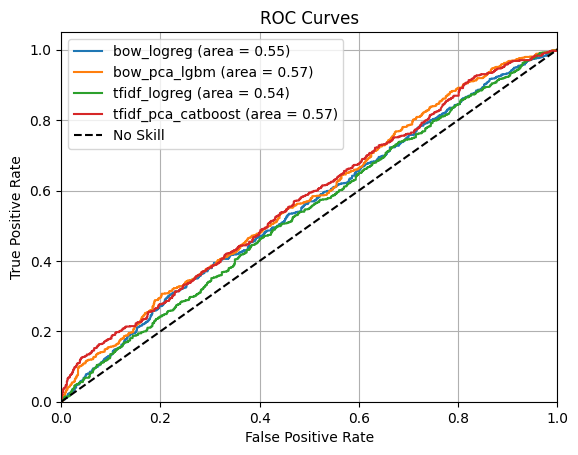

In [6]:
plt.figure()

for model in curves:
    curve = curves[model]
    plt.plot(curve['fpr'], curve['tpr'], label=f"{model} (area = {curve['roc_auc']:0.2f})")
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.title('ROC Curves')
plt.legend()
plt.show()